# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
</div>
****

In [46]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [90]:
# percentage of callbacks for black-sounding names
cb_rate_b = len(data[(data.race=='b') & (data.call==1.0)]) / len(data[data.race == 'b'])

# percentage of callbacks for white-sounding names
cb_rate_w = len(data[(data.race=='w') & (data.call==1.0)]) / len(data[data.race == 'w'])

# percentage difference
percent_diff = str(int(cb_rate_b / (cb_rate_w + cb_rate_b) * 100)) + '%'

print('In our sample, resumes with white names are ' + percent_diff + ' more likely '
      'to get a callback than resumes with black names.')

In our sample, resumes with white names are 40% more likely to get a callback than resumes with black names.


### What test is appropriate for this problem? Does CLT apply?
I'll be using a two-sample bootstrap hypothesis test for difference of means. The mean is an accurate proxy for callback rate, as the `data.call` column is boolean.

I'm on V4, which seems to cover CLT much less (hacker statistics being slightly less theoretical in that way) but, a quick look at the histogram below shows the CLT at work. 

### What are the null and alternate hypotheses?
My test statistic is the difference in callback-rates, which I refer to as the callback-rate differential. My null hypothesis is that this differential is equal to zero, and my alternative hypothesis is that it is larger than zero.


### Compute margin of error, confidence interval, and p-value.
Below is the margin of error and confidence interval for the callback-rate differential, and then a hypothesis test using the null hypothesis that the callback-rate for black is as high as for whites.

In [83]:
replicates = np.empty(10000)

b = data[(data.race=='b')].call
w = data[(data.race=='w')].call

def cb_rate_diff(series1, series2):
    return (len(series1[series1 == 1.0]) / len(series1)) - (len(series2[series2 == 1.0]) / len(series2))

samp_b_cb = cb_rate_diff(w, b)

for i in range(10000):
    perm_b = np.random.choice(b, len(b))
    perm_w = np.random.choice(w, len(w))
    
    replicates[i] = cb_rate_diff(perm_w, perm_b)
    
conf_int = np.percentile(replicates, [2.5,97.5])
print('The callback-rate differential in the sample is ' + str(samp_b_cb))
print('The 95% confidence interval for this statistic is ' + str(conf_int))
print('The margin of error is ' + str((conf_int[1] - conf_int[0]) / 2))

The callback-rate differential in the sample is 0.032032854209445585
The 95% confidence interval for this statistic is [ 0.01683778  0.04722793]
The margin of error is 0.0151950718686


In [84]:
bs_replicates_b = np.empty(10000)
bs_replicates_w = np.empty(10000)

b = data[(data.race=='b')].call
w = data[(data.race=='w')].call

# Compute mean callback-rate for both races.
mean_cb = np.mean(np.concatenate((b, w)))

# Generate shifted arrays from mean_cb.
b_shifted = b - np.mean(b) + mean_cb
w_shifted = w - np.mean(w) + mean_cb 

# Compute 10,000 bootstrap replicates for each shifted array.
for i in range(10000):
    bootstrap_b = np.random.choice(b_shifted, size=len(b))
    bootstrap_w = np.random.choice(w_shifted, size=len(w))
    
    bs_replicates_b[i] = np.mean(bootstrap_b)
    bs_replicates_w[i] = np.mean(bootstrap_w)

# Get replicates of difference of means.
bs_replicates = bs_replicates_w - bs_replicates_b

# Compute and print p-value and some analysis.
p = np.sum(bs_replicates >= (np.mean(w) - np.mean(b))) / 10000

print('Our original sample had a callback-rate differential of ' + str(np.mean(w) - np.mean(b)))
print('Our p-value = ' + str(p))
print('This reflects a very low probability of getting a callback-rate differential this large if '
      'the population callback-rate differential were truly zero.')

Our original sample had a callback-rate differential of 0.0320329
Our p-value = 0.0
This reflects a very low probability of getting a callback-rate differential this large if the population callback-rate differential were truly zero.


### Write a story describing the statistical significance in the context or the original problem.

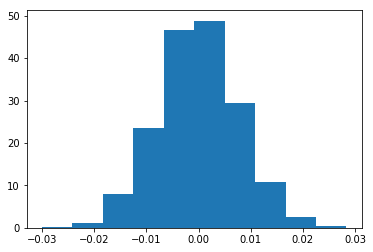

In [82]:
plt.hist(bs_replicates, normed=True)
None

I'm fascinated by these ultra-low p-values and how to interpret them. What I did above is shift the callback rates for whites and blacks so that their means were equal and, from this hypothetical 'population' where racial bias did not come into play, I calculated the odds of getting a callback-rate differential as large as 0.032. 

As can be seen in this histogram, we get zero samples that have a callback-rate differential this large. This suggests that our finding that individuals with black-sounding names are *significantly* less likely to get a callback from submitting a resume is indeed significantly significant and unlikely to be the result of random sampling error.

### Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

No. This question compares the effect of race/name with other factors that can affect callback, but we have only tested race. To find out the most important factor, we would have to repeat this process for every factor listed in our table. Given the presence of 65 columns, it is likely that some other factor (such as years experience or education) may play a more dominant role.